In [1]:
#lines for google colab
#!pip install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f https://data.pyg.org/whl/torch-1.10.0+cu111.html
#!pip install forgi
#!tar -xf data.tar.xz
import os
import datetime
import numpy as np
import torch as th
import torch_geometric.transforms as T
from torch_geometric.loader import DenseDataLoader, DataLoader
import torch.nn.functional as F
import matplotlib.pyplot as plt
from classifier.data import CGDataset
from classifier.model import Diff_CG_Classifier, MinCut_CG_Classifier, DMoN_CG_Classifier #, MinCut2_CG_Classifier
from classifier.train import pool_train_loop
from classifier.test import pool_test_loop

print("Pytorch Version", th.__version__)
print("Cuda is available:", th.cuda.is_available())

device = th.device("cuda" if th.cuda.is_available() else "cpu")
print("Using device:", device)

vectorize = True
k = 0

#Training Set
training_dir = "data/train_set"
rmsd_list = "data/truncated_train_rmsd.txt" #"data/train_rmsd_list.txt" #
training_dataset = CGDataset(training_dir, rmsd_list, vectorize, k)#, transform=T.ToDense(64))

#Validation Set
val_dir = "data/val_set"
val_rmsd = "data/val_rmsd_list.txt"
val_dataset = CGDataset(val_dir, val_rmsd, vectorize, k)#, transform=T.ToDense(64))

#Test Data
test_dir = "data/test_set"
test_rmsd = "data/test_rmsd_list.txt"
test_dataset = CGDataset(test_dir, test_rmsd, vectorize, k)#, transform=T.ToDense(64))

#5S rRNA and tRNA Test Data (previous training data)
st_test_dir = "data/old_training_set"
st_test_rmsd = "data/old_train_rmsd_list.txt"
st_test_dataset = CGDataset(st_test_dir, st_test_rmsd, vectorize, k)#, transform=T.ToDense(64))

#Rotated Test Sets
test_dir_rot = "data/test_set_rot"
test_rmsd = "data/test_rmsd_list.txt"
rot_test_dataset = CGDataset(test_dir_rot, test_rmsd, vectorize, k)#, transform=T.ToDense(64))

fst_test_rot = "data/5st_test_rot"
fst_rot_dataset = CGDataset(fst_test_rot, st_test_rmsd, vectorize, k)#, transform=T.ToDense(64))

Pytorch Version 1.11.0
Cuda is available: True
Using device: cuda


TODO:
*  **Check why fewer graphs are loaded into the training dataset than are in the rmsd list**
*  Change data preparation so that s0 is always at [0, 0, 1, 0, y_e, 1] **DONE**
*  Add further that start of s1 is in xy-plane with s0
*  Use A-Minor Interactions as an additional edge for graph construction **DONE**
*  are there additional tertiary interactions detected to add?
*  Integrate (Root) Mean Squared Error, Mean Absolute Error or other Regression Related Metric **DONE** 
*  softplus or relu for last classification step? if any non-linearity that ensures that no negative results are returned?
*  add link prediction loss and entropy regularization to the loss function **DONE**
*  which noramlization to use?
*  try skip-cat/-sum in layer architecture

In [ ]:
#Training
model = MinCut_CG_Classifier(training_dataset.num_node_features)

parent_dir = "run_data/"


#epoch_losses, val_losses, mae_losses, learning_rates, epoch_add_losses = 
#with th.autograd.detect_anomaly():
pool_train_loop(
    model=model,
    train_dataset=training_dataset,
    val_dataset=val_dataset,
    model_dir=parent_dir,
    device=device,
    b_size=64,
    lr=1e-3,
    epochs=5_000,
    sched_T0=50,
    vectorize=vectorize,
    k=k,
    resume="run_data/2022-05-17_12-18_MinCut_CG_Classifier/model_data/epoch_4516.pth",
    burn_in=0)

In [2]:
#get training run data

run_dir = "run_data/2022-05-17_12-18_MinCut_CG_Classifier"
burn_in = 50

file_lines = []
with open(run_dir + "/loss_data.txt", "r") as fh:
    for line in fh.readlines():
        file_lines.append(line.rstrip("]\n").lstrip("[").split(","))

epoch_losses = [float(a) for a in file_lines[0]]
val_losses = [float(b) for b in file_lines[1]]
learning_rates = [float(c) for c in file_lines[2]]
mae_losses = [float(d) for d in file_lines[3]]
epoch_add_losses = [float(d) for d in file_lines[4]]

print(f"Minimum Training Loss {min(epoch_losses):.4f} in epoch {epoch_losses.index(min(epoch_losses))}")
print(f"Minimum Validation Loss (after {burn_in} epochs) {min(val_losses[burn_in:]):.4f} in epoch {val_losses.index(min(val_losses[burn_in:]))}")
print(f"Minimum MAE (after {burn_in} epochs) {min(mae_losses[burn_in:]):.4f} in epoch {mae_losses.index(min(mae_losses[burn_in:]))}")


Minimum Training Loss 0.2237 in epoch 4887
Minimum Validation Loss (after 50 epochs) 13.4218 in epoch 4406
Minimum MAE (after 50 epochs) 13.6739 in epoch 4406


In [10]:
print(len(epoch_losses))

5000


Validation Loss at 4516 is 13.5346
5 before select
13.5551, 13.5198, 13.6433, 13.5319, 13.4995
5 after select
13.5852, 13.5416, 13.4946, 13.6269, 13.5595
MAE at 4516 is 13.7834


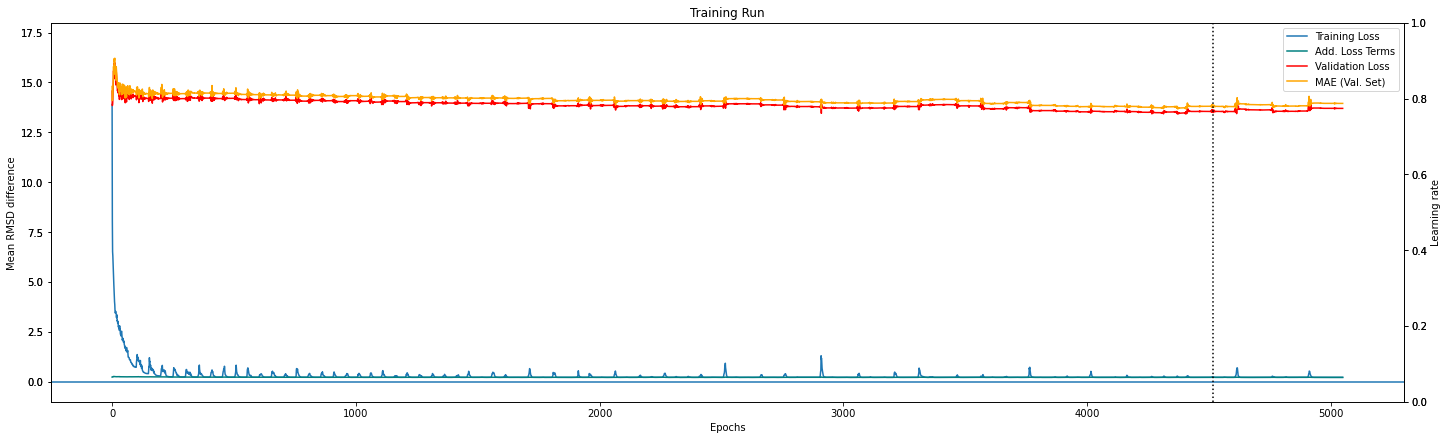

In [3]:
#plot the training run
select = 4516

print(f"Validation Loss at {select} is {val_losses[select]:.4f}")
print("5 before select")
print((", ").join([f"{x:.4f}" for x in val_losses[select-5:select]]))
print("5 after select")
print((", ").join([f"{y:.4f}" for y in val_losses[select+1:select+6]]))
print(f"MAE at {select} is {mae_losses[select]:.4f}")

fig, ax1 = plt.subplots(layout="constrained", figsize=(20, 6))
ax1.secondary_yaxis("left")
ax1.plot(epoch_losses, label="Training Loss")
ax1.plot(epoch_add_losses, "teal", label="Add. Loss Terms")
ax1.plot(val_losses, "r", label="Validation Loss")
ax1.plot(mae_losses, "orange", label="MAE (Val. Set)")
ax2 = ax1.twinx()
ax2.secondary_yaxis("right")
#ax2.plot(learning_rates, "g", label="Learning Rate")
plt.title("Training Run")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Mean RMSD difference")
ax2.set_ylabel("Learning rate")
ax1.set_ybound(lower=-1, upper=max(val_losses)+2)
plt.axvline(x = select, c = "black", ls = ':')
ax1.axhline(y=0)
han1, lab1 = ax1.get_legend_handles_labels()
han2, lab2 = ax2.get_legend_handles_labels()
plt.legend(han1 + han2, lab1 + lab2, loc="upper right")
plt.draw()

Model not in global variables
Using state dict from epoch 4516
Test Set
Minimum Loss: Label = 23.3560, Prediction = 23.3175, Loss = 0.0007
Maximum Loss: Label = 0.0000, Prediction = 28.2012, Loss = 27.7012
Mean Test loss: 	 11.9483
Std. Dev. of Test loss:  7.8678
Min loss: 		 0.0007
First Quantile: 	 5.4263
Median: 		 11.1016
Third Quantile: 	 19.2006
Max Loss: 		 27.7012
LinregressResult(slope=-0.6531527140397053, intercept=30.98185639707739, rvalue=-0.19960661055457987, pvalue=0.00083544839393677, stderr=0.19335020660576616, intercept_stderr=4.259540868411941)


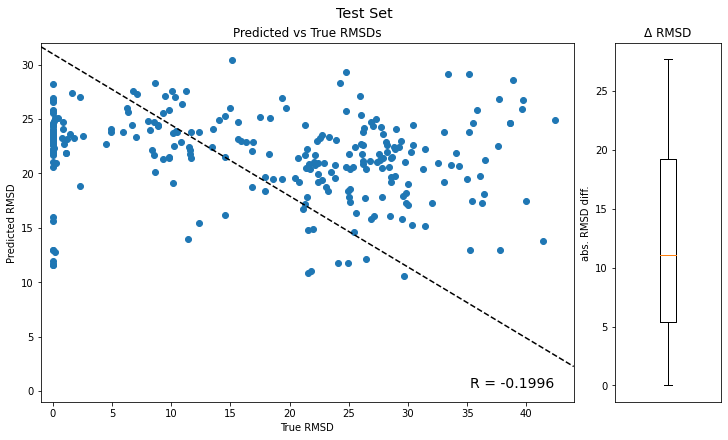

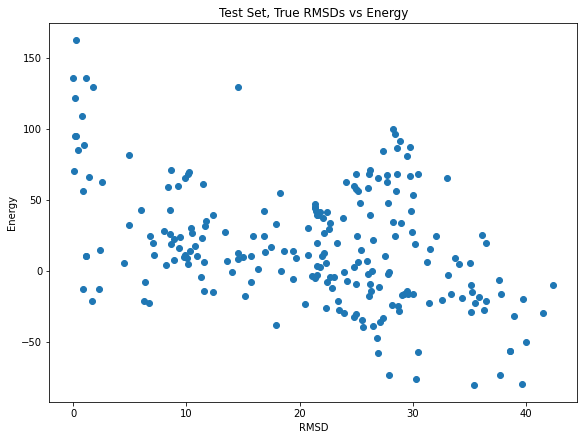

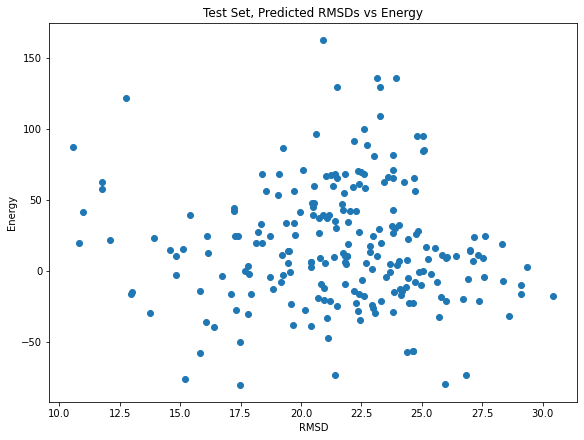

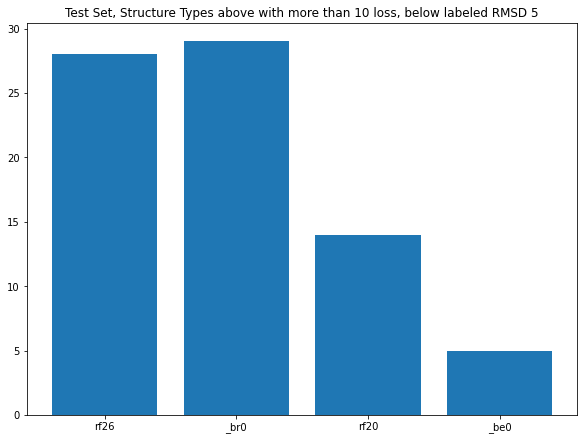

5S and tRNA Test Set
Minimum Loss: Label = 15.4510, Prediction = 15.4539, Loss = 0.0000
Maximum Loss: Label = 0.0000, Prediction = 26.6791, Loss = 26.1791
Mean Test loss: 	 3.7944
Std. Dev. of Test loss:  4.5135
Min loss: 		 0.0000
First Quantile: 	 0.8127
Median: 		 2.3946
Third Quantile: 	 4.8316
Max Loss: 		 26.1791
LinregressResult(slope=0.9082250592888158, intercept=-0.2323275534791467, rvalue=0.7497421992968452, pvalue=4.631228790102013e-196, stderr=0.024380888176252065, intercept_stderr=0.4686828544452981)


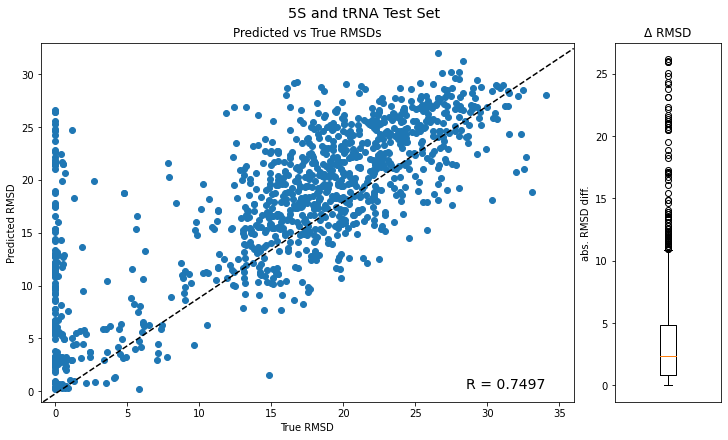

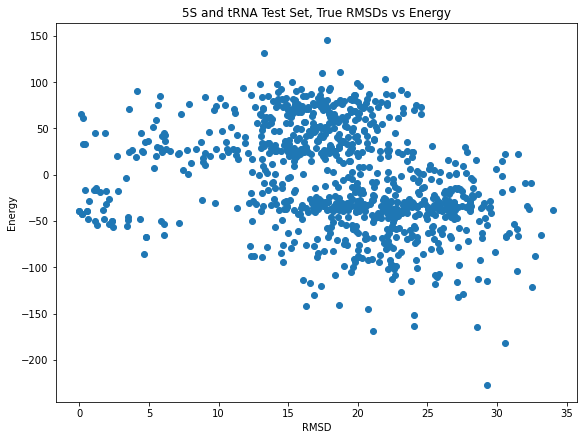

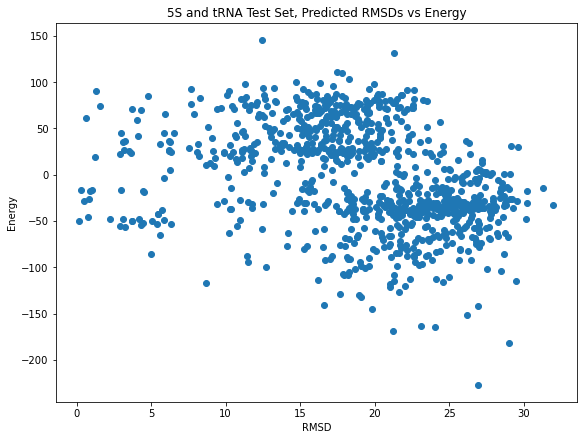

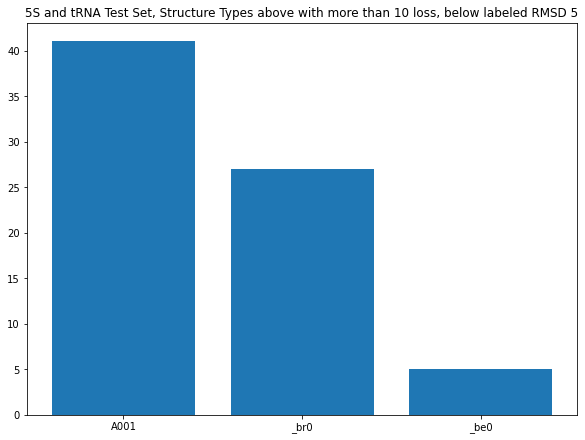

Training Set
Minimum Loss: Label = 18.4610, Prediction = 18.4608, Loss = 0.0000
Maximum Loss: Label = 22.3450, Prediction = 21.0165, Loss = 0.8285
Mean Test loss: 	 0.0310
Std. Dev. of Test loss:  0.0622
Min loss: 		 0.0000
First Quantile: 	 0.0032
Median: 		 0.0114
Third Quantile: 	 0.0298
Max Loss: 		 0.8285
LinregressResult(slope=1.0101743718853813, intercept=-0.02073424967132098, rvalue=0.9998330610405288, pvalue=0.0, stderr=0.0006705172778286152, intercept_stderr=0.013363709473406234)


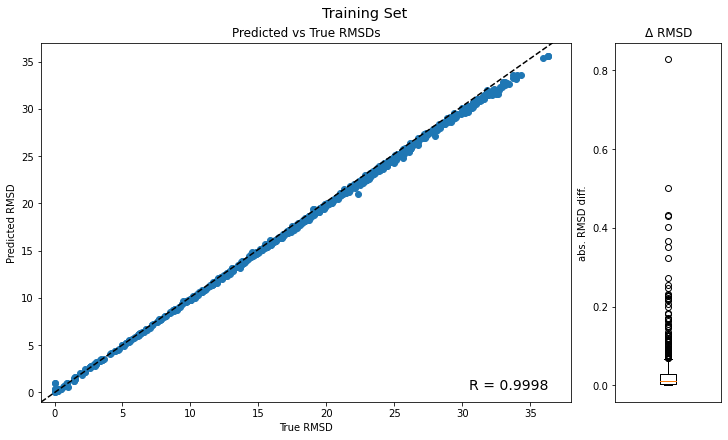

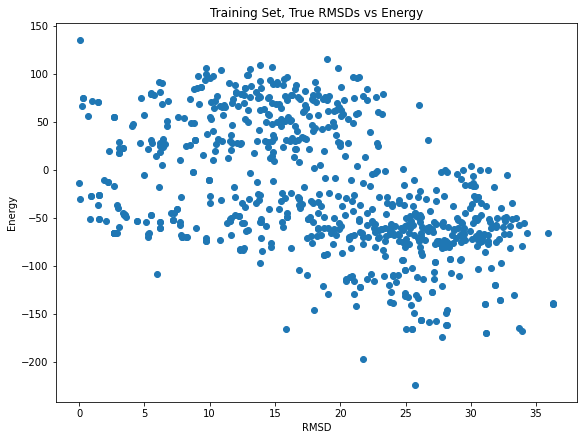

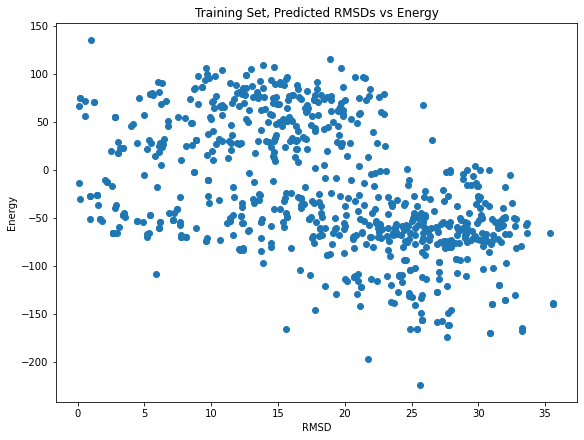

Validation Set
Minimum Loss: Label = 26.2310, Prediction = 26.3683, Loss = 0.0094
Maximum Loss: Label = 60.2560, Prediction = 11.5153, Loss = 48.2407
Mean Test loss: 	 13.1200
Std. Dev. of Test loss:  9.4839
Min loss: 		 0.0094
First Quantile: 	 4.7883
Median: 		 11.8604
Third Quantile: 	 19.9966
Max Loss: 		 48.2407
LinregressResult(slope=0.1633198401097835, intercept=19.63401605707087, rvalue=0.050872706127533376, pvalue=0.31258736246183016, stderr=0.16152631393199277, intercept_stderr=3.6616446154039406)


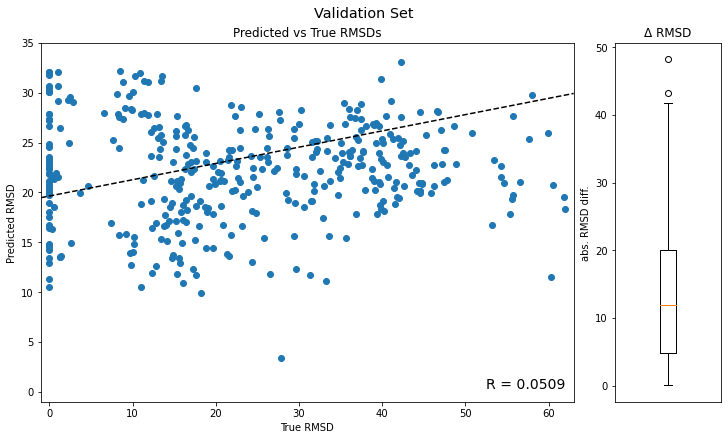

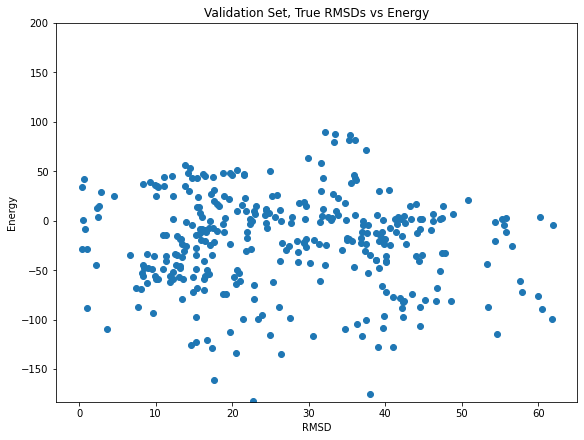

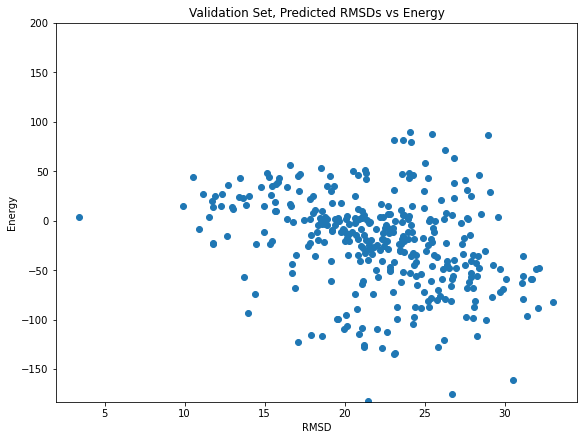

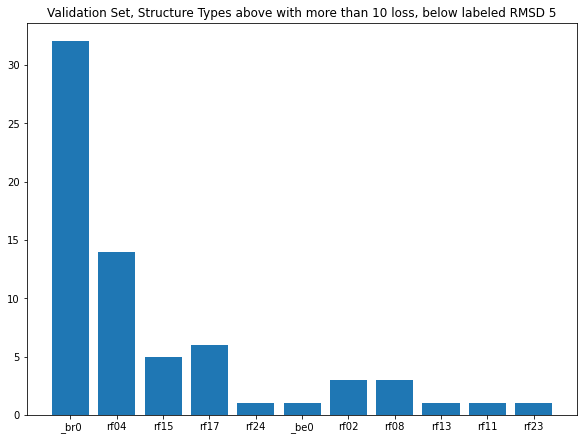

LinregressResult(slope=0.6733516548075394, intercept=7.198205762695187, rvalue=0.3889950399576796, pvalue=4.729663790198573e-55, stderr=0.04132598697914642, intercept_stderr=0.8701150603384381)


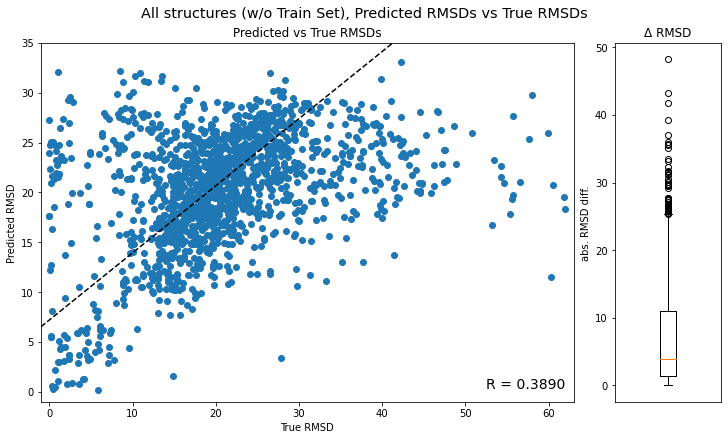

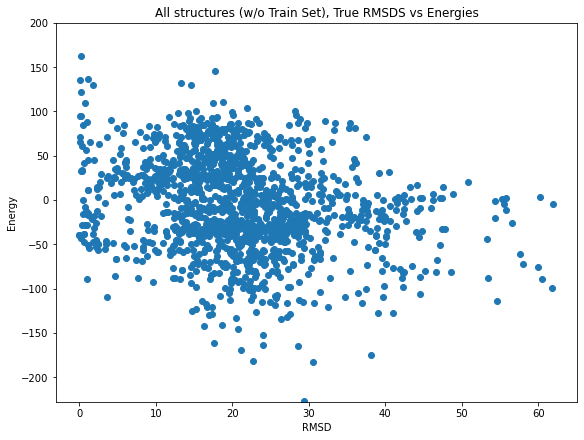

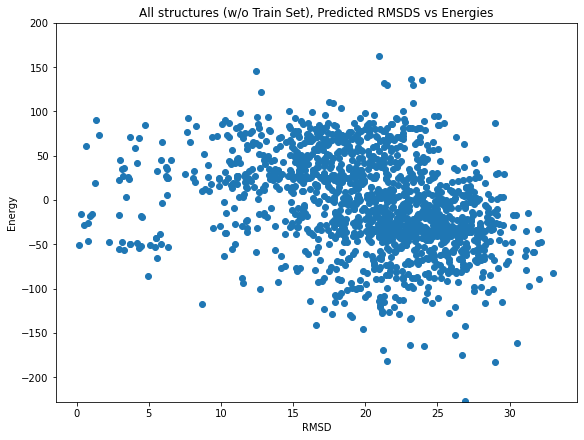

In [4]:
#Test
from classifier.utility import get_energy_dict, rmsd_scatter, e_rmsd_scatter

# loss cutoff for type histo
cutoff = [10, 5]

if "model" not in globals():
    print("Model not in global variables")
    model = MinCut_CG_Classifier(training_dataset.num_node_features).to(device)

train_loader = DataLoader(training_dataset, batch_size=1)
val_loader = DataLoader(val_dataset, batch_size=1)
test_dataloader = DataLoader(test_dataset, batch_size=1)
st_test_dataloader = DataLoader(st_test_dataset, batch_size=1)

model.to(device)
checkpoint = th.load(f"{run_dir}/model_data/epoch_{select}.pth")
print(f"Using state dict from epoch {checkpoint['epoch']}")
model.load_state_dict(checkpoint["model_state_dict"])

energy_l = []
true_rmsd_l = []
pred_rmsd_l = []
test_ls = []
for loader in [test_dataloader, st_test_dataloader, train_loader, val_loader]:
    if loader == test_dataloader:
        title = "Test Set"
        e_dict = get_energy_dict("data/test_energy.txt")
    elif loader == st_test_dataloader:
        title = "5S and tRNA Test Set"
        e_dict = get_energy_dict("data/old_train_energy.txt")
    elif loader == train_loader:
        title = "Training Set"
        e_dict = get_energy_dict("data/train_energy.txt")
    elif loader == val_loader:
        title = "Validation Set"
        e_dict = get_energy_dict("data/val_energy.txt")
    en, trs, prs, tlosses = pool_test_loop(model, loader, e_dict, title, device, cutoff)
    if loader != train_loader:
        energy_l += en
        true_rmsd_l += trs
        pred_rmsd_l += prs
        test_ls += tlosses

        

rmsd_scatter(pred_rmsd_l, true_rmsd_l, test_ls, "All structures (w/o Train Set), Predicted RMSDs vs True RMSDs")
e_rmsd_scatter(energy_l, true_rmsd_l, "All structures (w/o Train Set), True RMSDS vs Energies")
e_rmsd_scatter(energy_l, pred_rmsd_l, "All structures (w/o Train Set), Predicted RMSDS vs Energies")

LinregressResult(slope=0.9659905783684367, intercept=0.537258868637597, rvalue=0.9449597906955881, pvalue=1.88364745503116e-135, stderr=0.020169195083693397, intercept_stderr=0.44974023222810006)


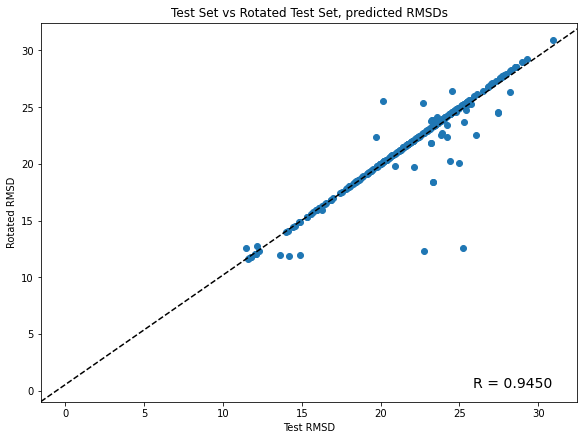

LinregressResult(slope=0.9611611313725212, intercept=0.26131886222848166, rvalue=0.9867132468706287, pvalue=4.4805133980998683e-219, stderr=0.009543681141798736, intercept_stderr=0.13846034877432134)


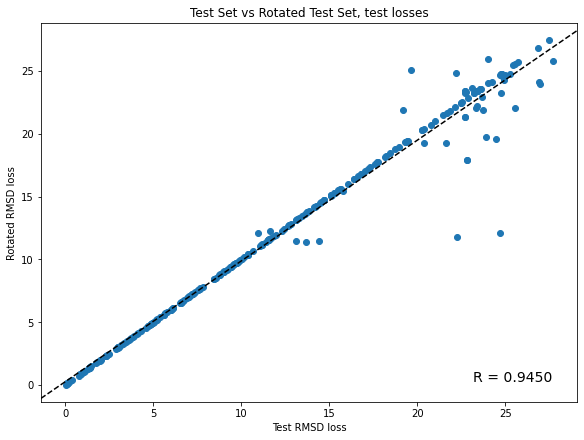

LinregressResult(slope=0.9735337763322951, intercept=0.5090134622150586, rvalue=0.9763802091458228, pvalue=0.0, stderr=0.006552280498648748, intercept_stderr=0.12753543845014378)


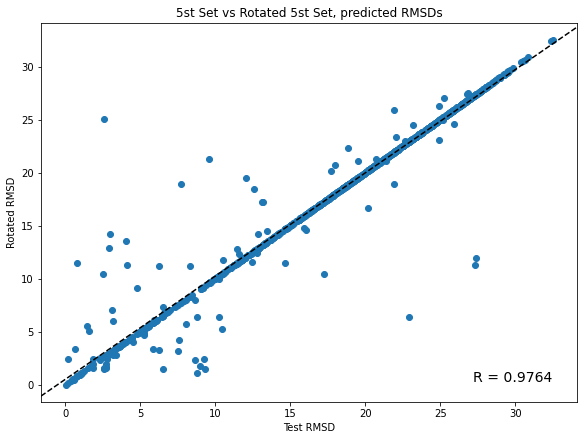

LinregressResult(slope=0.9535347058794745, intercept=0.21654675190014228, rvalue=0.94123451548374, pvalue=0.0, stderr=0.010407010100400928, intercept_stderr=0.06388867406612253)


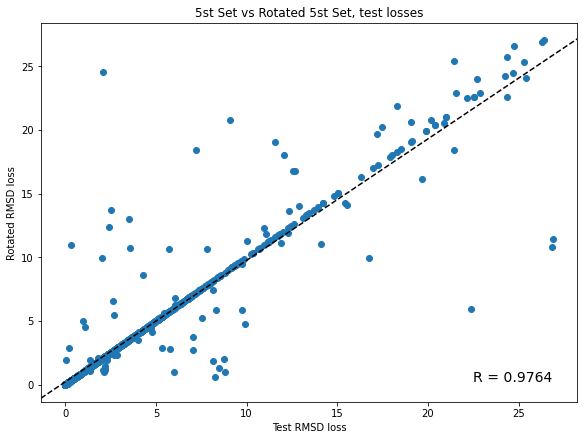

In [7]:
#Test run for rotational invariance
from scipy.stats import linregress
rot_test_dataloader = DataLoader(rot_test_dataset, batch_size=1)
fst_rot_dataloader = DataLoader(fst_rot_dataset, batch_size=1)

def rot_eval(dataloader, rot_dataloader):
    pred_dir = {}
    loss_dir = {}
    for loader in [dataloader, rot_dataloader]:
        with th.no_grad():
            model.eval()
            for test_graph in loader:
                test_graph = test_graph.to(device)
                test_pred, _ = model(test_graph)
                test_loss = F.smooth_l1_loss(test_pred, test_graph.y).item()

                if test_graph.name[0] not in pred_dir.keys():
                    pred_dir[test_graph.name[0]] = [float(test_pred)]
                else:
                    pred_dir[test_graph.name[0]].append(float(test_pred))
                
                if test_graph.name[0] not in loss_dir.keys():
                    loss_dir[test_graph.name[0]] = [float(test_loss)]
                else:
                    loss_dir[test_graph.name[0]].append(float(test_loss))
    return pred_dir, loss_dir

def rot_plot(pred_dir, loss_dir, title):
    test_preds = []
    trot_preds = []
    for a in pred_dir.keys():
        test_preds.append(pred_dir[a][0])
        trot_preds.append(pred_dir[a][1])

    test_ls = []
    trot_ls = []
    for b in loss_dir.keys():
        test_ls.append(loss_dir[b][0])
        trot_ls.append(loss_dir[b][1])

    reg = linregress(test_preds, trot_preds)
    print(reg)

    fig1, axs1 = plt.subplots(layout='constrained', figsize=(8, 6))
    plt.title(title + ", predicted RMSDs")
    axs1.scatter(test_preds, trot_preds)
    axs1.axline(xy1=(0, reg.intercept), slope=reg.slope, linestyle="--", color="k")
    axs1.text(max(test_preds), 0.01, f"R = {reg.rvalue:.4f}", fontsize=14, verticalalignment="bottom", horizontalalignment="right")
    plt.xlabel("Test RMSD")
    plt.ylabel("Rotated RMSD")
    plt.show()

    reg_l = linregress(test_ls, trot_ls)
    print(reg_l)

    fig2, axs2 = plt.subplots(layout='constrained', figsize=(8, 6))
    plt.title(title + ", test losses")
    axs2.scatter(test_ls, trot_ls)
    axs2.axline(xy1=(0, reg_l.intercept), slope=reg_l.slope, linestyle="--", color="k")
    axs2.text(max(test_ls), 0.01, f"R = {reg.rvalue:.4f}", fontsize=14, verticalalignment="bottom", horizontalalignment="right")
    plt.xlabel("Test RMSD loss")
    plt.ylabel("Rotated RMSD loss")
    plt.show()

test_pred_dir, test_loss_dir = rot_eval(test_dataloader, rot_test_dataloader)
rot_plot(test_pred_dir, test_loss_dir, "Test Set vs Rotated Test Set")

fst_pred_dir, fst_loss_dir = rot_eval(st_test_dataloader, fst_rot_dataloader)
rot_plot(fst_pred_dir, fst_loss_dir, "5st Set vs Rotated 5st Set")